Bayesian Dynamic Linear Modeling

https://liveproject.manning.com/module/251_1_3/bayesian-dynamic-linear-modeling/introduction/start-project?  

https://livebook.manning.com/book/probabilistic-deep-learning/probabilistic-deep-learning/  
https://pydlm.github.io/example1.html  
https://github.com/wwrechard/PyDLM  
https://pydlm.github.io/  

1. Build a simple DLM model with a defined linear trend and seasonal component.  

2. Select an appropriate seasonal period and discounting factor when constructing the model.

3. Plot the fitted results, for example plots of the filtered series, one-day prediction, and smoothed series.

4. Plot the predictions for the training set, along with the forecast and associated confidence bands for the test set. Use a split partition of your choice and comment on your interpretation of this forecast, when constructing the notebook. Interpret the model accuracy using RMSE.

The deliverable for this project is a Jupyter Notebook outlining a simple DLM forecast on weekly cancellation trends.

In [1]:
import os
import datetime as dt
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,8)

In [2]:
bookings_file = os.path.join('data', 'h2weekly.csv')
df = pd.read_csv(bookings_file)

In [3]:
df.shape

(115, 2)

In [4]:
df.head()

,Date,IsCanceled
0,2015-06-21,97
1,2015-06-28,153
2,2015-07-05,228
3,2015-07-12,321
4,2015-07-19,159


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.sort_values(by=['Date'])

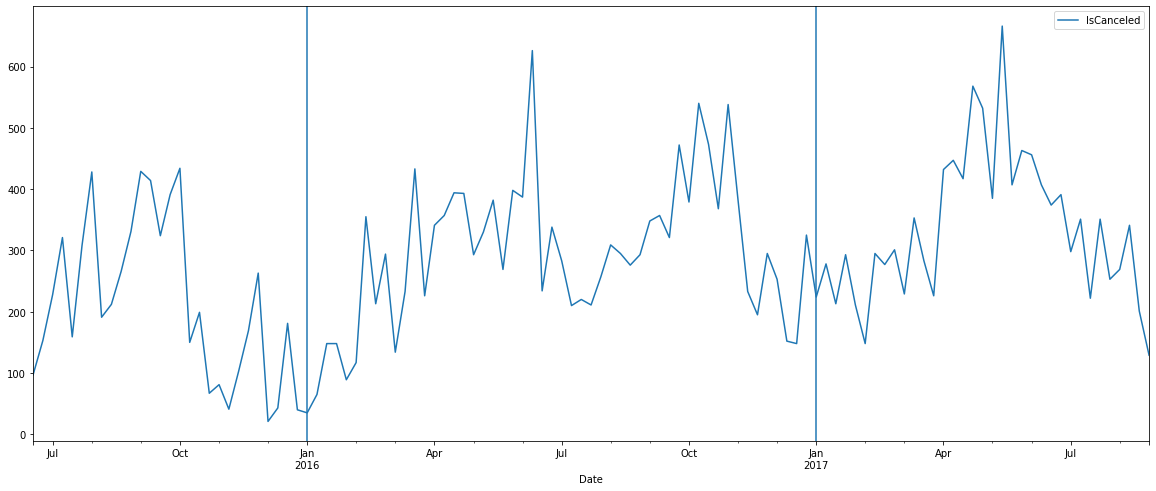

In [7]:
df.set_index('Date').plot()
plt.axvline(dt.datetime(2016, 1, 1))
plt.axvline(dt.datetime(2017, 1, 1))

In [8]:
df.dtypes

Date          datetime64[ns]
IsCanceled             int64
dtype: object

In [9]:
time_series = df['IsCanceled']

### Correlation plots

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

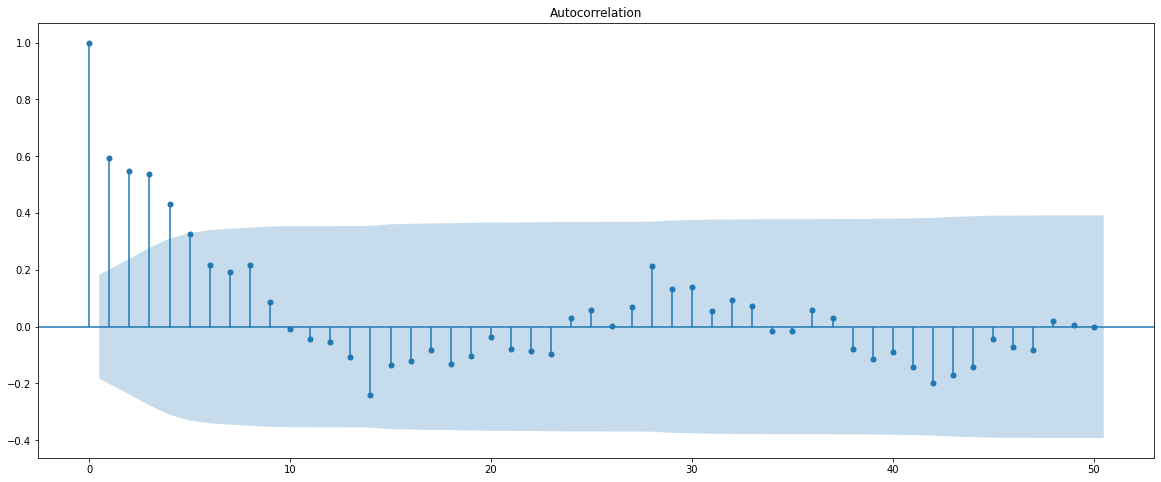

In [11]:
plot_acf(time_series, lags=50);

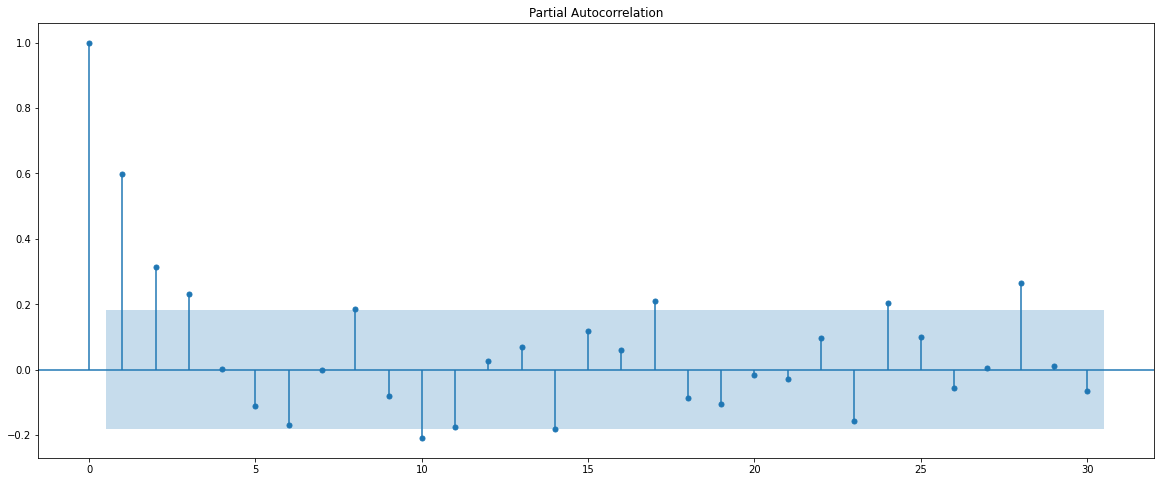

In [12]:
plot_pacf(time_series, lags=30);

The partial autocorrelation plot shows a good correlation at lag=28. Set seasonality value to this.

### Build the model  
DLM - Dynamic linear model

In [13]:
from pydlm import dlm, trend, seasonality, modelTuner

degree=1 indicates the trend is a linear (2 stands for quadratic)   
period=52 means the seasonality has a periodicy of 52  
w=10 is the prior guess on the variance of each component, the larger number the more uncertain  

Note: "Hint for defining the linear trend of the simple dlm:" formatted incorrectly in notes and the hint is repeated.

In [14]:
linear_trend = trend(degree=1, discount=0.9, name='linear_trend', w=10)
seasonal28 = seasonality(period=28, discount=0.9, name='seasonal28', w=10)
simple_dlm = dlm(time_series) + linear_trend + seasonal28

In [15]:
simple_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


/home/garyb/dev/manning/BayesianTimeSeries/venv/lib/python3.6/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


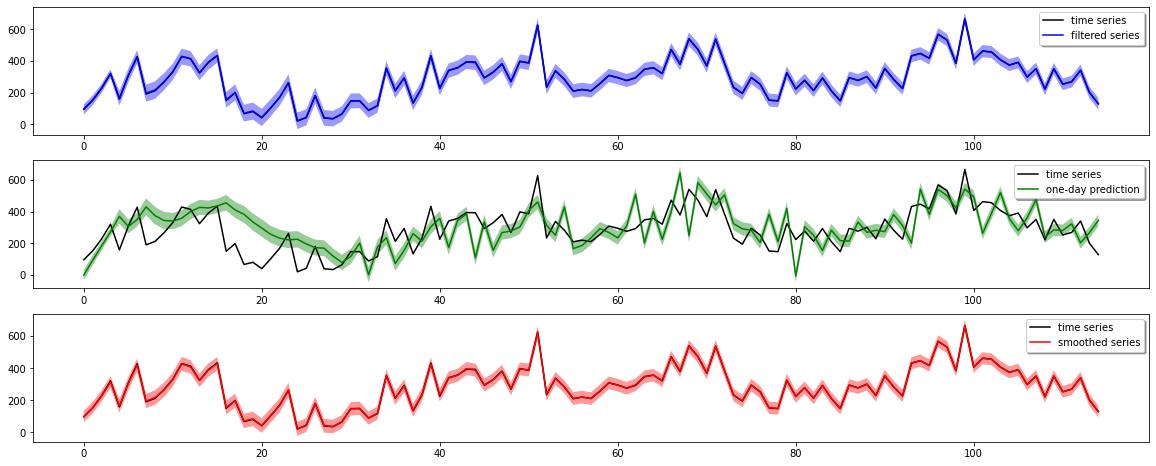

In [16]:
simple_dlm.turnOff('data points')
simple_dlm.plot()

The blue curve is the forward filtering result  
the green curve is the one-day ahead prediction  
the red curve is the backward smoothed result.

In [17]:
simple_dlm.ls()

The static components are
linear_trend (degree = 2)
seasonal28 (degree = 28)
 
There is no dynamic component.
 
There is no automatic component.


In [18]:
print(f'RMSE: {math.sqrt(simple_dlm.getMSE())}')

RMSE: 124.28653141706431


In [19]:
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(simple_dlm, maxit=100)

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


In [20]:
tuned_discounts = myTuner.getDiscounts()
tuned_discounts

[0.99999, 0.99999]

Unable to tune the model

### Plot fitted results

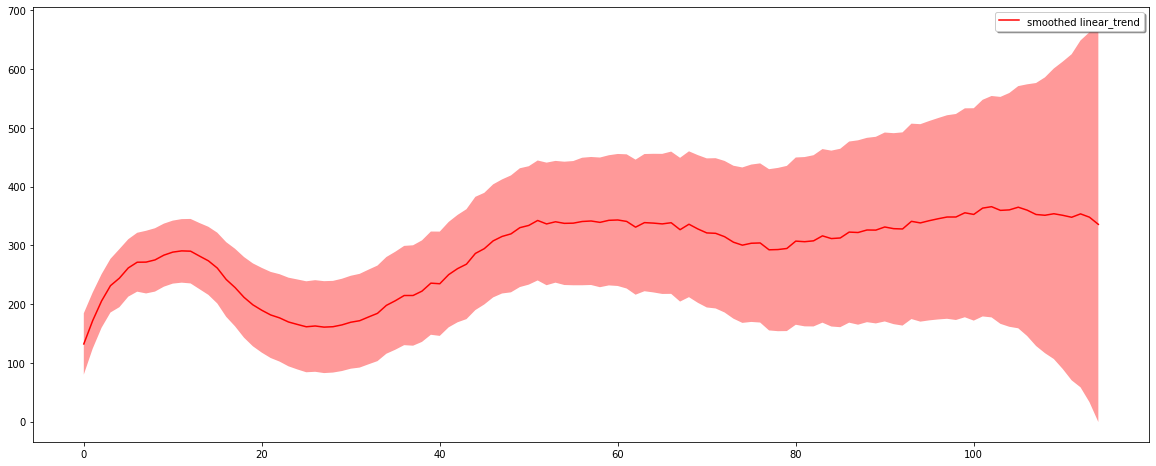

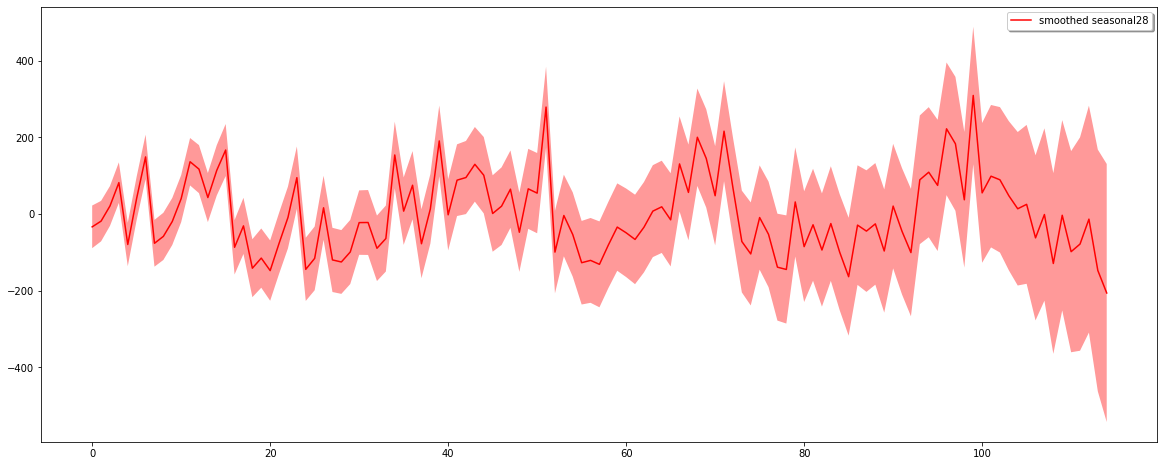

In [21]:
# Plot each component (attribute the time series to each component)
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal28')

### Plot prediction

In [22]:
# time_series.count()
split_point = int(time_series.count() * 1//3.0)
split_point
time_series.count()

115

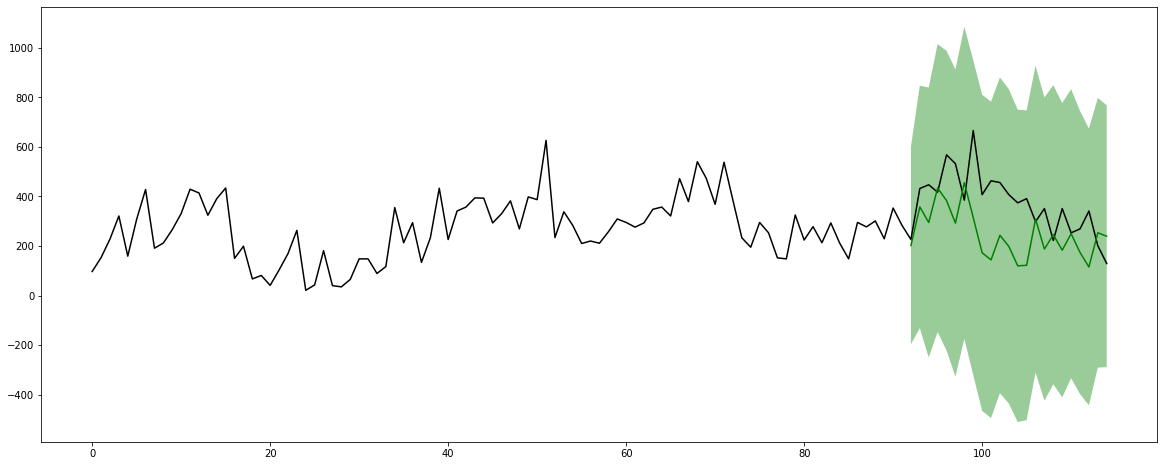

In [23]:
# Plot Plot the prediction for the last 20% given the first 80%
split_ratio = 0.8

test_size = int(time_series.count() * split_ratio)
pred_size = time_series.count() - test_size
simple_dlm.plotPredictN(date=test_size, N=pred_size)

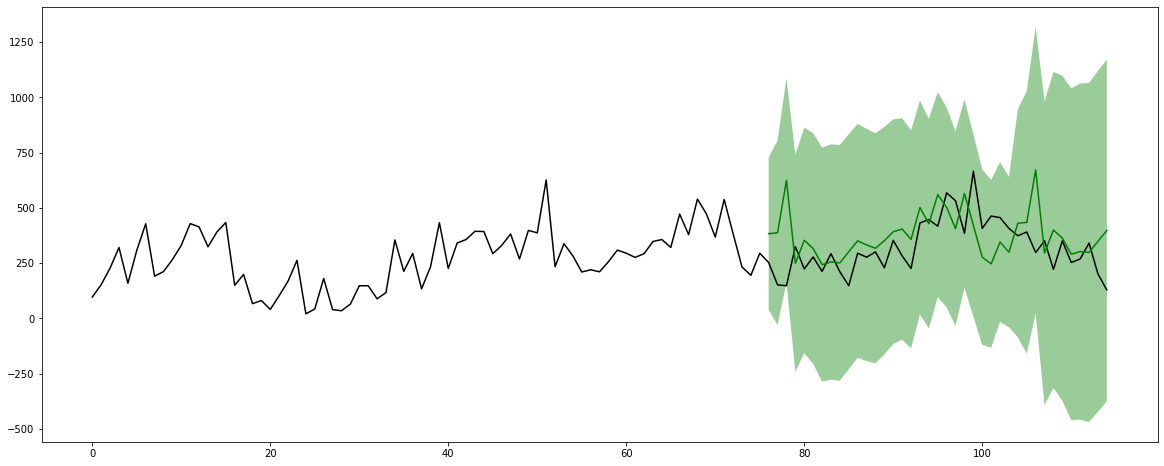

In [24]:
# Plot Plot the prediction for the last 1/3 given the first 2/3
split_ratio = 2/3.0

test_size = int(time_series.count() * split_ratio)
pred_size = time_series.count() - test_size
simple_dlm.plotPredictN(date=test_size, N=pred_size)

See how the prediction is for the 80/20 split

In [25]:
# Generate the prediction for the last 20% given the first 80%
split_ratio = 0.8

test_size = int(time_series.count() * split_ratio)
pred_size = time_series.count() - test_size

pred = simple_dlm.predictN(date=test_size, N=pred_size)  # [pred_mean, pred_variance]

In [26]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(time_series[-pred_size:].values, pred[0])
rmse = math.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 182.12973909521733


The mean error in the model is about 182. This isn't too bad and fairly close to actual values.
However the predicted variance is quite high suggesting there is a lot of noise/uncertainty in the model.

# Bayesian Dynamic Linear Modeling - Dynamic & Autoregressive Components

In [27]:
from pydlm import dynamic, autoReg

In [28]:
dynamic_dlm = simple_dlm + autoReg(degree=2, name='ar2', w=1.0)

In [29]:
features = [[1.0, 2.0] for i in range(115)]
ctrend = dynamic(features=features, name='random', discount = 0.9)
dynamic_dlm = dynamic_dlm + ctrend

In [30]:
dynamic_dlm.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


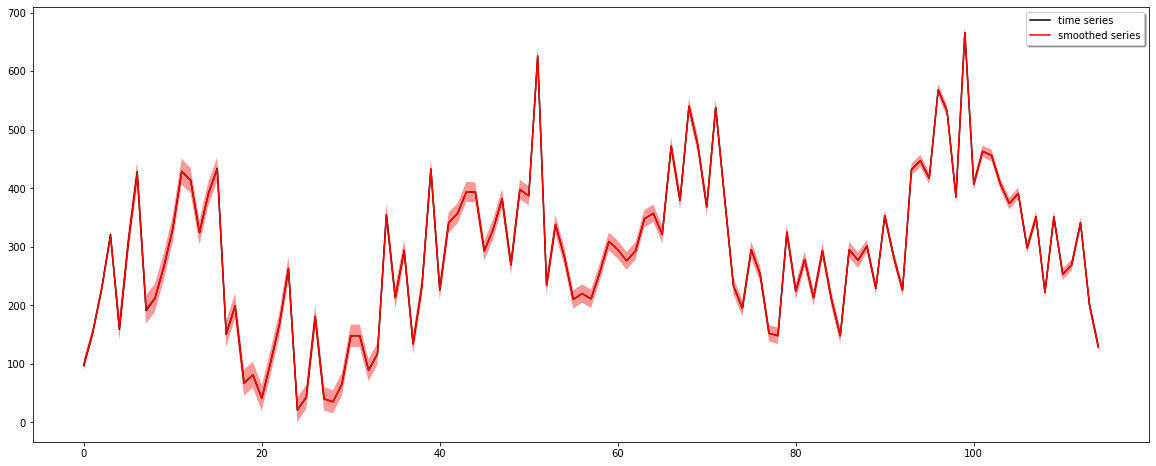

In [32]:
dynamic_dlm.turnOff('data points')
dynamic_dlm.plot()

/home/garyb/dev/manning/BayesianTimeSeries/venv/lib/python3.6/site-packages/pydlm/plot/dlmPlot.py:519: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(str(size[0]) + str(size[1]) + str(location))


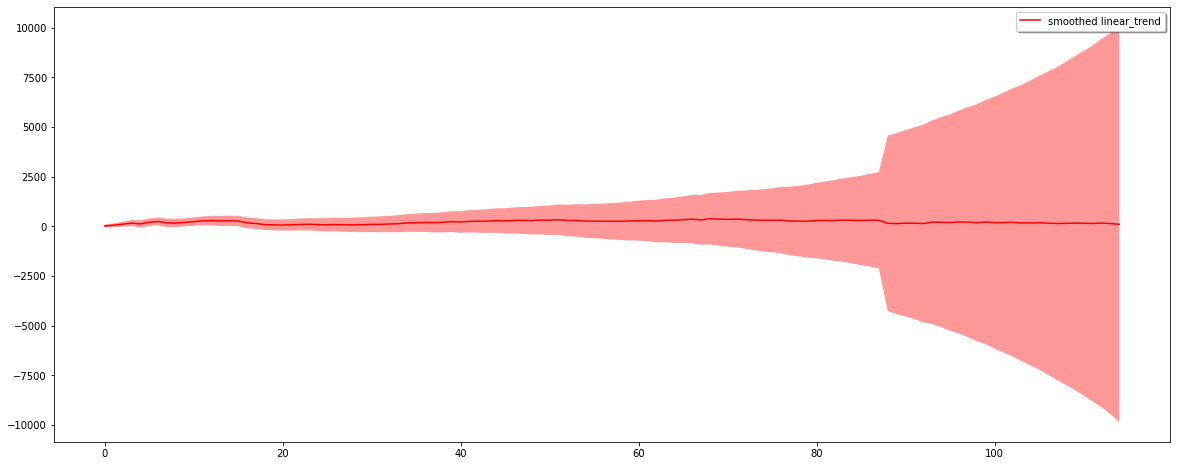

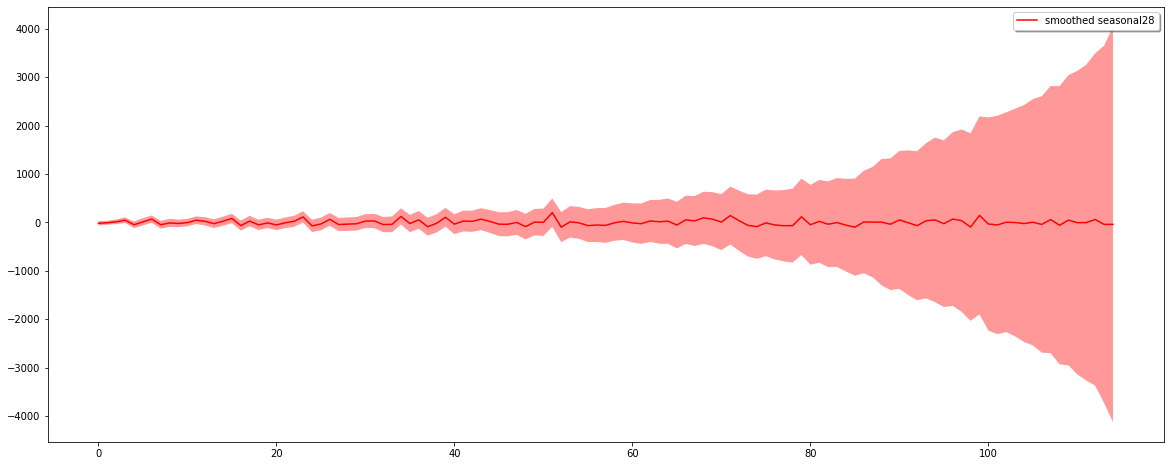

In [31]:
# Plot each component (attribute the time series to each component)
dynamic_dlm.turnOff('predict plot')
dynamic_dlm.turnOff('filtered plot')
dynamic_dlm.plot('linear_trend')
dynamic_dlm.plot('seasonal28')

In [35]:
pred_size

23

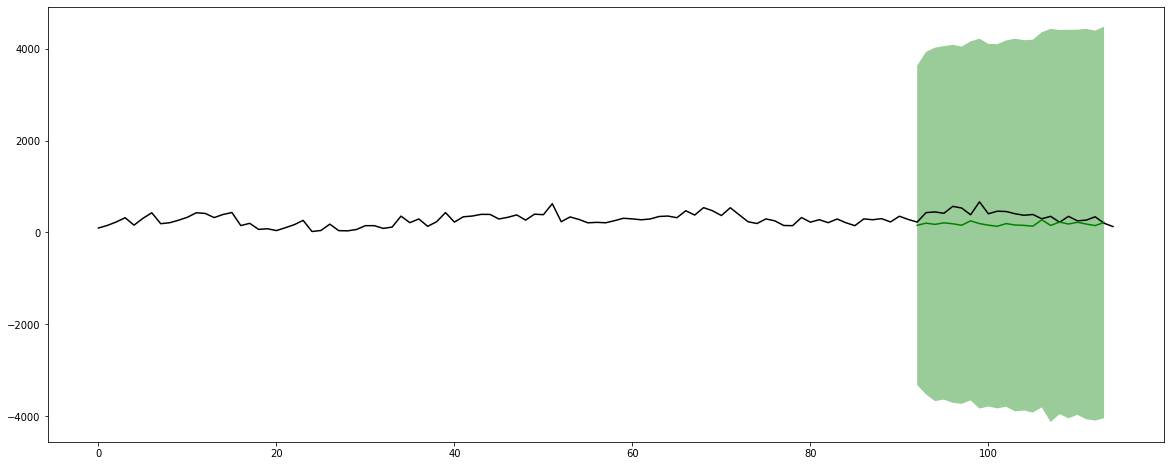

In [36]:
# Plot Plot the prediction for the last 20% given the first 80%
split_ratio = 0.8

test_size = int(time_series.count() * split_ratio)
pred_size = time_series.count() - test_size - 1
dynamic_dlm.plotPredictN(date=test_size, N=pred_size)

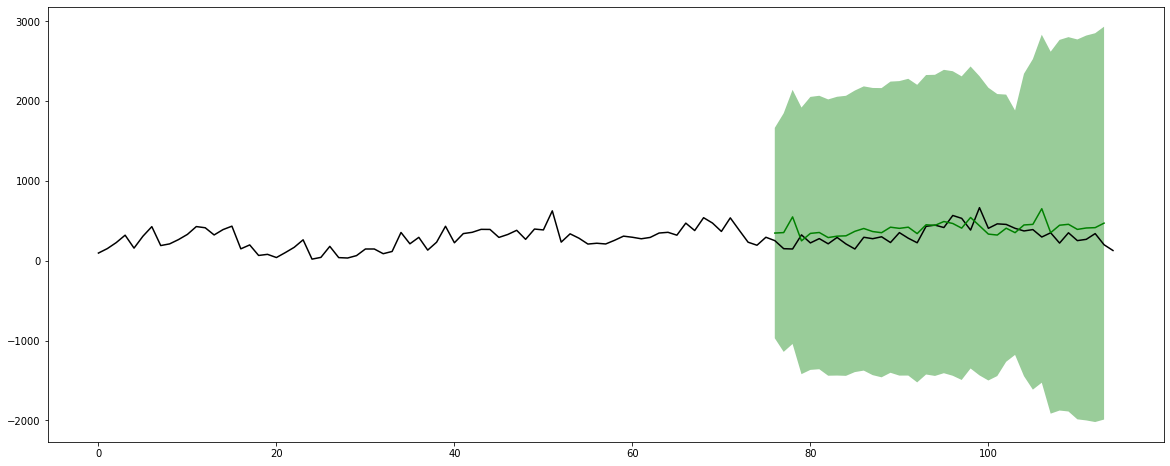

In [39]:
# Plot Plot the prediction for the last 1/3 given the first 2/3
split_ratio = 2/3.0

test_size = int(time_series.count() * split_ratio)
pred_size = time_series.count() - test_size - 1
dynamic_dlm.plotPredictN(date=test_size, N=pred_size)

In [40]:
pred = dynamic_dlm.predictN(date=test_size, N=pred_size)  # [pred_mean, pred_variance]

In [41]:
mse = mean_squared_error(time_series[-pred_size:].values, pred[0])
rmse = math.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 139.02205939478472


RMSE has dropped from 182 to 139 an improvement of about 24%. The dynamic component has really improved the model.